In [347]:
import warnings
warnings.filterwarnings('ignore')

In [348]:
import pandas as pd,numpy as np
import matplotlib.pyplot as plt,seaborn as sns
import statsmodels.api as sm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data Reading & Understanding

In [349]:
df=pd.read_csv('day.csv')


In [350]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [351]:
df.shape

(730, 16)

In [352]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


There are no null values in the dataset

In [353]:
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


### Dropping irrelevant features
 - instant is index - we can drop it
 - dteday is conveying the same meaning as yr & mnth
 - casual & registered can be removed as it totals to the target value 'cnt' & possibly be a reason of data leakage

In [354]:
df.drop(['instant','dteday','casual','registered'],axis=1,inplace=True)

In [355]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


## Data Preparation
#### Mapping data according to dictionary
this step is done prior to visualization so that it can have meaningful item names

In [356]:
df.season = df.season.map({1: 'Spring',2:'Summer',3:'Fall',4:'Winter'})

In [357]:
df.yr = df.yr.map({0: '2018',1:'2019'})

In [358]:
import calendar
df.mnth = df.mnth.apply(lambda x:calendar.month_name[x])
df.mnth = df.mnth.apply(lambda x:x[:3])


In [359]:
df.weekday = df.weekday.map({0:"Sun",1:"Mon",2:"Tue",3:"Wed",4:"Thr",5:"Fri",6:"Sat"})


In [360]:
df.weathersit = df.weathersit.map({1:'Clear_FewClouds_PartlyCloudy',
                                   2:'Mist_CloudyMist_BrokenClouds_FewClouds', 
                                   3:'LightSnow_LightRain_Thunderstorm_ScatteredClouds',
                                   4:'HeavyRain_IcePallets_Thunderstorm_Mist_Snow_Fog'})


# Data Visualization

First we categorize features into categoricals & continuous

In [361]:
cat_f=['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit']
cont_f=['temp', 'atemp', 'hum', 'windspeed','cnt']


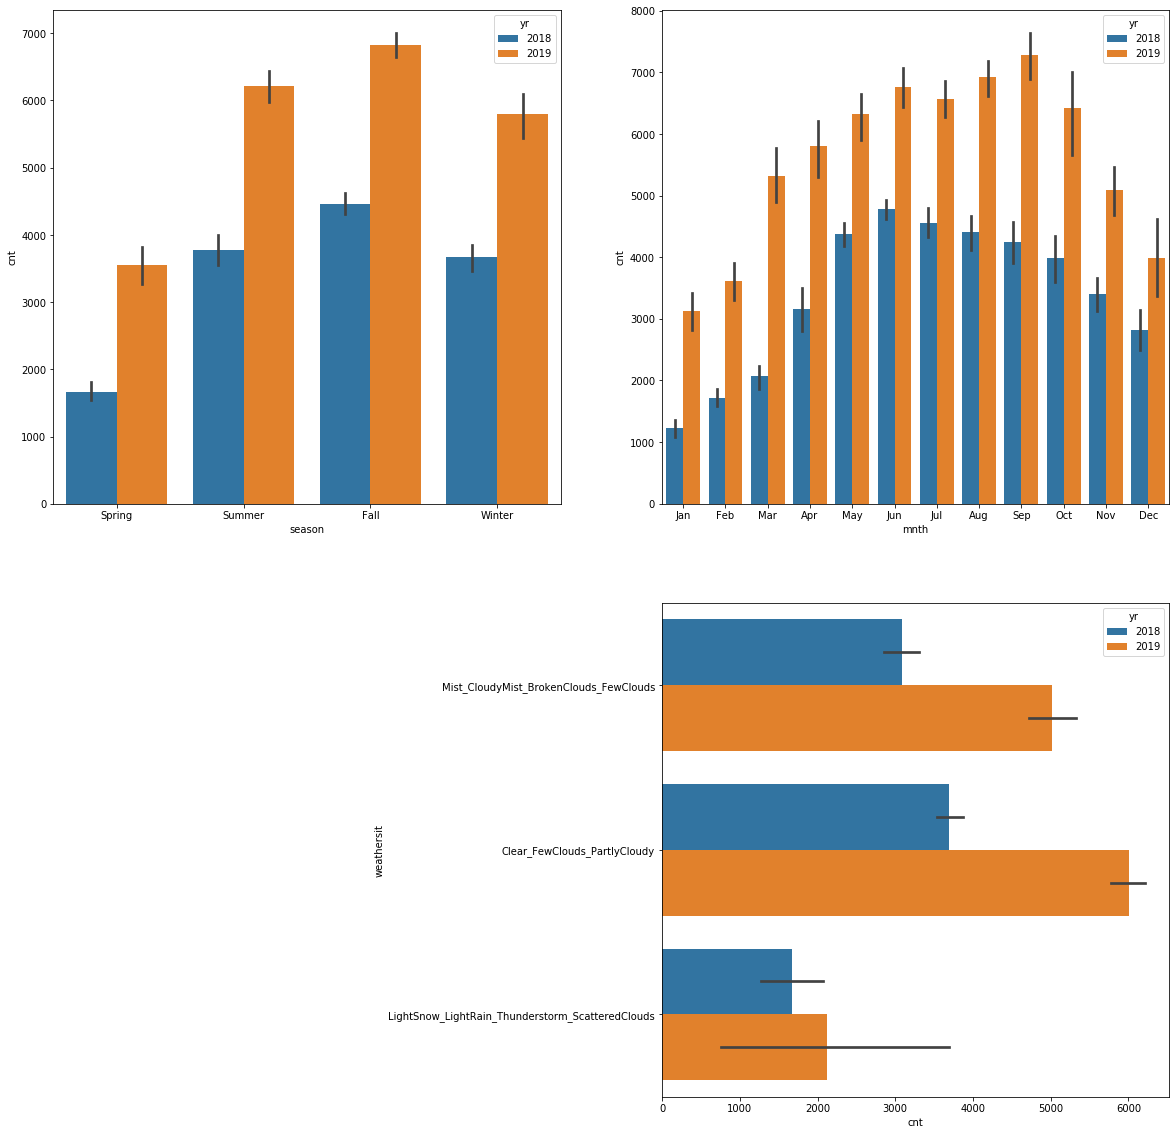

In [367]:
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
sns.barplot(x=df.season,y=df.cnt,hue=df.yr,data=df)
plt.subplot(2,2,2)
sns.barplot(x=df.mnth,y=df.cnt,hue=df.yr,data=df)
plt.subplot(2,2,4)
sns.barplot(y=df.weathersit,x=df.cnt,hue=df.yr,data=df)
plt.show()

## Inferences
- The overall trend increases in 2019
- Summer,winter & fall sees good rentals
- the trend increases from march then dips in december

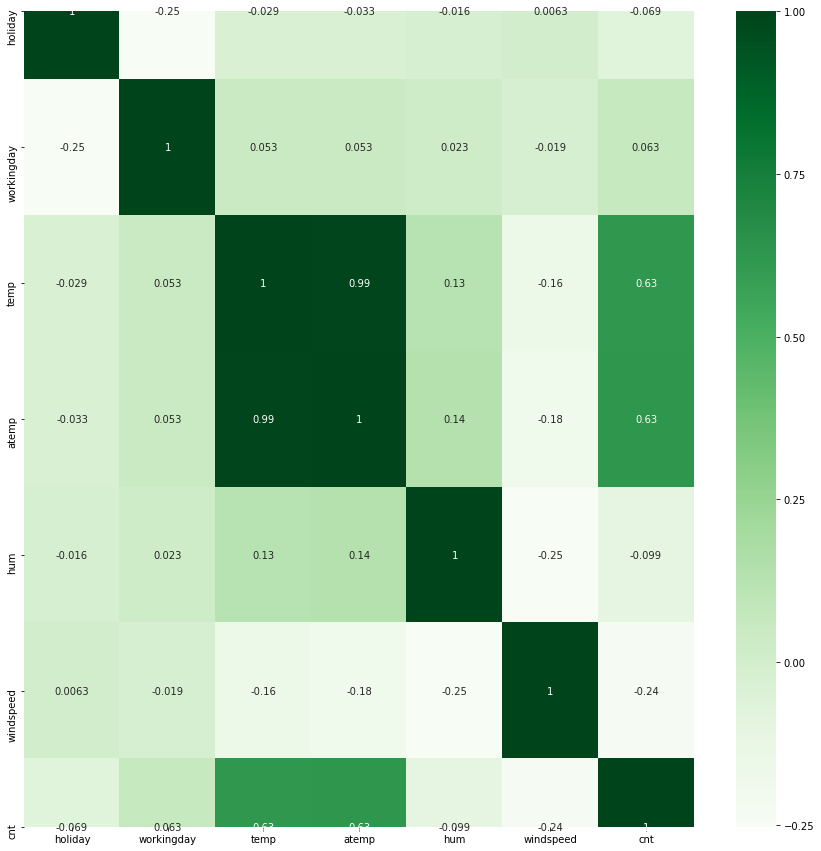

In [291]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot = True, cmap="Greens")
plt.show()

### Inferences
- The temp & atemp is highly correlated but we will not drop them now, we will let the model decide which is more important

### Continuous Variables

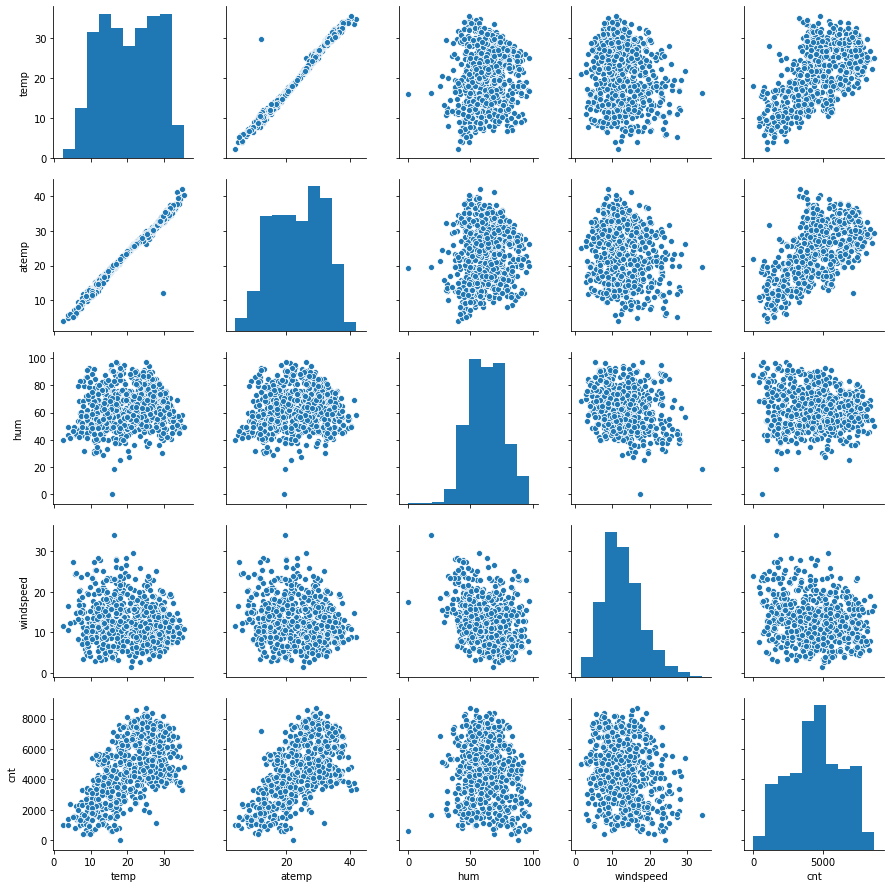

In [292]:
sns.pairplot(data=df[cont_f])

### Categorical Variables

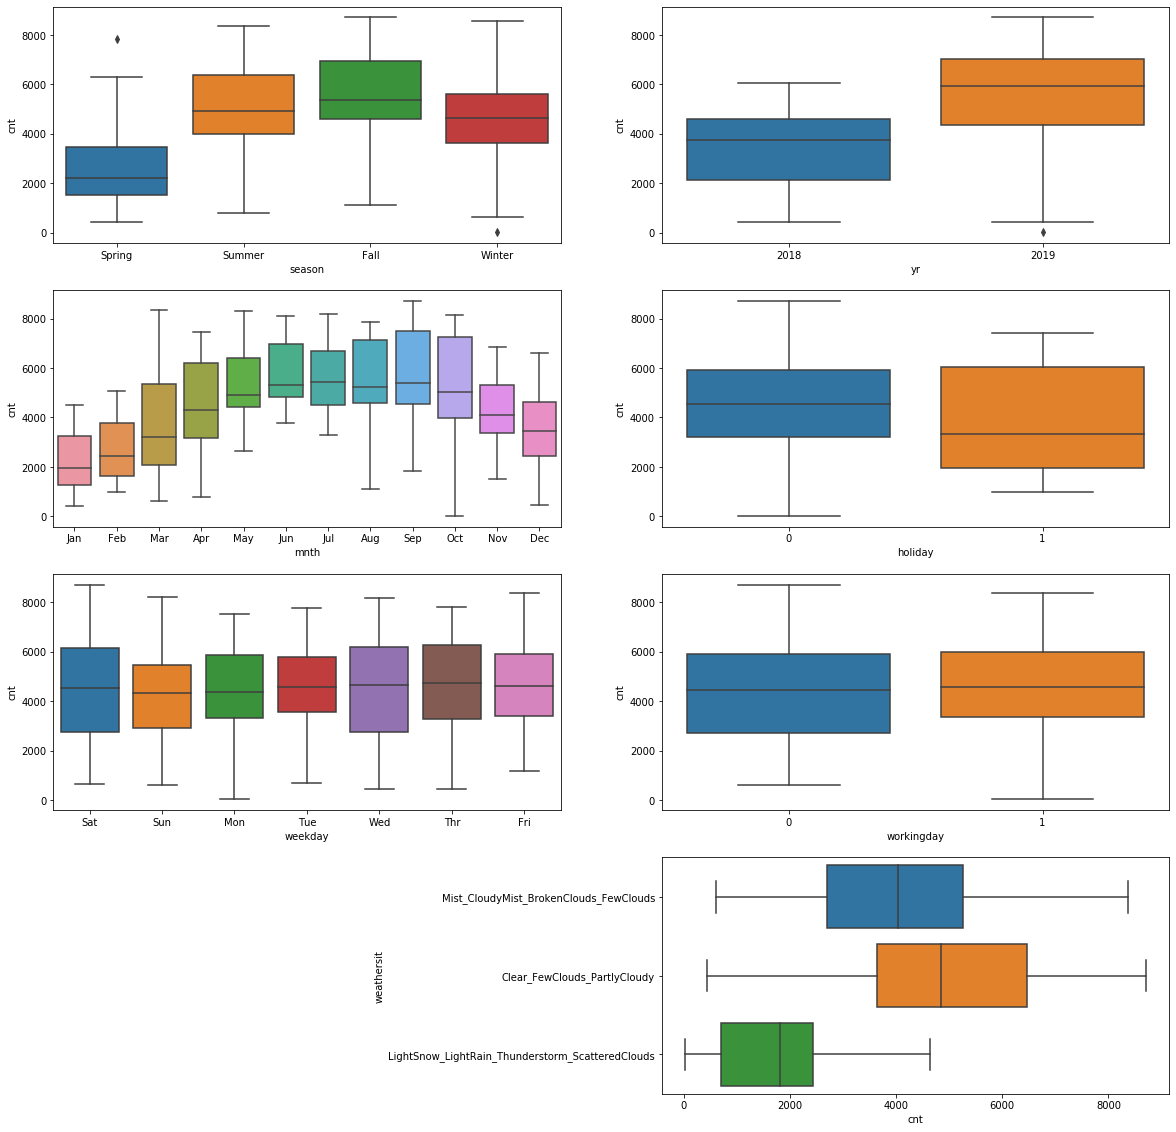

In [293]:
plt.figure(figsize=(20,20))
plt.subplot(4,2,1)
sns.boxplot(x=df.season,y=df.cnt,data=df)
plt.subplot(4,2,2)
sns.boxplot(x=df.yr,y=df.cnt,data=df)
plt.subplot(4,2,3)
sns.boxplot(x=df.mnth,y=df.cnt,data=df)
plt.subplot(4,2,4)
sns.boxplot(x=df.holiday,y=df.cnt,data=df)
plt.subplot(4,2,5)
sns.boxplot(x=df.weekday,y=df.cnt,data=df)
plt.subplot(4,2,6)
sns.boxplot(x=df.workingday,y=df.cnt,data=df)
plt.subplot(4,2,8)
sns.boxplot(y=df.weathersit,x=df.cnt,data=df)
plt.show()

## Inferences
- The number of rentals increased in 2019
- The rentals increase from summer & decreases towards winter but is still higher than Spring
- The rentals increases from Aprill but dips in July & is most in september
- There is a dip during holidays & non workingday
- There is no rentals during Heavy Rain or Ice pallets

# Data Preparation Contd..

### Dummy Variables
Creating dummy variables for categoricals

In [294]:
dummy=df[['season','mnth','weathersit','weekday','yr']]
dummy=pd.get_dummies(dummy,drop_first=True)

df=pd.concat([df,dummy],axis=1)

In [295]:
df.drop(['season','mnth','weathersit','weekday','yr'],axis=1,inplace=True)

In [296]:
df.shape

(730, 30)

In [297]:
df.head()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_Spring,season_Summer,season_Winter,...,mnth_Sep,weathersit_LightSnow_LightRain_Thunderstorm_ScatteredClouds,weathersit_Mist_CloudyMist_BrokenClouds_FewClouds,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thr,weekday_Tue,weekday_Wed,yr_2019
0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,0,...,0,0,1,0,1,0,0,0,0,0
1,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,0,...,0,0,1,0,0,1,0,0,0,0
2,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,...,0,0,0,0,0,0,0,0,1,0


### Train Test Split
Splitting the dataset into train & test in 70:30 ratio

In [298]:
np.random.seed(0)
df_train,df_test=train_test_split(df,train_size=0.7,test_size=0.3,random_state=100)

### Scaling
Scaling the training dataset

In [299]:
scaler=MinMaxScaler()

In [300]:
df_train[cont_f]=scaler.fit_transform(df_train[cont_f])

In [301]:
df_train.head()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_Spring,season_Summer,season_Winter,...,mnth_Sep,weathersit_LightSnow_LightRain_Thunderstorm_ScatteredClouds,weathersit_Mist_CloudyMist_BrokenClouds_FewClouds,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thr,weekday_Tue,weekday_Wed,yr_2019
653,0,1,0.509887,0.501133,0.575354,0.300794,0.864243,0,0,1,...,0,0,0,0,0,0,0,1,0,1
576,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,0,...,0,0,0,0,0,0,0,1,0,1
426,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,0,...,0,0,1,0,1,0,0,0,0,1
728,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,0,...,0,0,0,0,0,1,0,0,0,1
482,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,0,...,0,0,1,0,1,0,0,0,0,1


In [302]:
df_train.describe()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_Spring,season_Summer,season_Winter,...,mnth_Sep,weathersit_LightSnow_LightRain_Thunderstorm_ScatteredClouds,weathersit_Mist_CloudyMist_BrokenClouds_FewClouds,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thr,weekday_Tue,weekday_Wed,yr_2019
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.00000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.025490,0.676471,0.537262,0.512989,0.650369,0.320768,0.513620,0.243137,0.245098,0.24902,...,0.080392,0.029412,0.343137,0.150980,0.154902,0.143137,0.133333,0.131373,0.158824,0.507843
std,0.157763,0.468282,0.225844,0.212385,0.145882,0.169797,0.224593,0.429398,0.430568,0.43287,...,0.272166,0.169124,0.475223,0.358381,0.362166,0.350557,0.340268,0.338139,0.365870,0.500429
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.540519,0.526811,0.653714,0.296763,0.518638,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,0.000000,0.00000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


we can see the min value is 0 & max is 1 after scaling

### Dividing data into dependent & independent variables

In [303]:
y_train=df_train.pop('cnt')
x_train=df_train


# Data Modelling and Evaluaion

First we will be building the model with all the given features in the dataset & remove them 1 by 1 using a combo of RFE & VIF/P-Val

### Model Building

In [304]:
#Linear Regression Model
lr = LinearRegression()
lr.fit(x_train, y_train)
#dropping down features count to 15 from 30 using RFE
rfe = RFE(lr, 15)           
rfe = rfe.fit(x_train, y_train)


In [305]:
#Checking features selected by RFE
rfe_cols=x_train.columns[rfe.support_]
rfe_cols

Index(['holiday', 'workingday', 'temp', 'hum', 'windspeed', 'season_Spring',
       'season_Summer', 'season_Winter', 'mnth_Jul', 'mnth_Sep',
       'weathersit_LightSnow_LightRain_Thunderstorm_ScatteredClouds',
       'weathersit_Mist_CloudyMist_BrokenClouds_FewClouds', 'weekday_Sat',
       'weekday_Sun', 'yr_2019'],
      dtype='object')

now using these columns we will proceed further & manually remove element as per statistical decisions following the statsmodel approach

In [306]:
x_train=x_train[rfe_cols]

In [307]:
#function for model creation
def model(x_train,y_train):
    x_train=sm.add_constant(x_train)
    lr=sm.OLS(y_train,x_train).fit()
    return lr,x_train

In [308]:
#VIF function
def VIF(x_train):
    X = x_train
    features = X.columns
    Vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif=pd.DataFrame({'Features':features,'VIF':Vif})
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

### Model 1

In [311]:
#adding constant & fitting model
lr,x_train=model(x_train,y_train)

In [313]:
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.3
Date:                Tue, 11 Jan 2022   Prob (F-statistic):          1.13e-191
Time:                        13:50:01   Log-Likelihood:                 517.87
No. Observations:                 510   AIC:                            -1006.
Df Residuals:                     495   BIC:                            -942.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [314]:
#VIF
VIF(x_train)


,Features,VIF
1,holiday,inf
2,workingday,inf
13,weekday_Sat,inf
14,weekday_Sun,inf
6,season_Spring,5.02
3,temp,3.62
8,season_Winter,3.49
7,season_Summer,2.61
4,hum,1.91
12,weathersit_Mist_CloudyMist_BrokenClouds_FewClouds,1.57


Removing holiday since its P value is beyond 5%  standing at 37.3% so it is clearly insignificant & VIF is inf which means it is perfectly collinear

In [318]:
x_train=x_train.drop(['holiday'],axis=1)

### Model 2

In [319]:
#rebuilding without holiday
lr2,x_train=model(x_train,y_train)

In [320]:
print(lr2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.3
Date:                Tue, 11 Jan 2022   Prob (F-statistic):          1.13e-191
Time:                        13:53:27   Log-Likelihood:                 517.87
No. Observations:                 510   AIC:                            -1006.
Df Residuals:                     495   BIC:                            -942.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

According to the P values the selected features are all significant so we will check for multicollinearity using VIF(<5 - Good)

In [321]:
#VIF
VIF(x_train)

,Features,VIF
0,const,114.08
1,workingday,9.07
12,weekday_Sat,6.06
13,weekday_Sun,5.74
5,season_Spring,5.02
2,temp,3.62
7,season_Winter,3.49
6,season_Summer,2.61
3,hum,1.91
11,weathersit_Mist_CloudyMist_BrokenClouds_FewClouds,1.57


We see many features having VIF>5 even though the P val made it significant. We will remove the 'workingday' & check again

## Model 3

In [322]:
x_train=x_train.drop(['workingday'],axis=1)

In [323]:
#rebuilding without workingday
lr3,x_train=model(x_train,y_train)

In [324]:
print(lr3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     203.8
Date:                Tue, 11 Jan 2022   Prob (F-statistic):          2.36e-189
Time:                        13:54:00   Log-Likelihood:                 509.56
No. Observations:                 510   AIC:                            -991.1
Df Residuals:                     496   BIC:                            -931.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [325]:
#VIF
VIF(x_train)


,Features,VIF
0,const,74.90
4,season_Spring,5.01
1,temp,3.62
6,season_Winter,3.49
5,season_Summer,2.61
2,hum,1.91
10,weathersit_Mist_CloudyMist_BrokenClouds_FewClouds,1.57
7,mnth_Jul,1.49
8,mnth_Sep,1.29
9,weathersit_LightSnow_LightRain_Thunderstorm_Sc...,1.25


we saw weekday_sat having a reducing VIF but the significance no longer holds true as P val is 0.218>0.05 so we remove it

## Model 4

In [326]:
x_train=x_train.drop(['weekday_Sat'],axis=1)

In [327]:
#rebuilding without weekday_Sat)
lr4,x_train=model(x_train,y_train)

In [328]:
print(lr4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     220.5
Date:                Tue, 11 Jan 2022   Prob (F-statistic):          3.31e-190
Time:                        13:55:26   Log-Likelihood:                 508.78
No. Observations:                 510   AIC:                            -991.6
Df Residuals:                     497   BIC:                            -936.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [329]:
#VIF
VIF(x_train)

,Features,VIF
0,const,74.37
4,season_Spring,5.01
1,temp,3.61
6,season_Winter,3.49
5,season_Summer,2.61
2,hum,1.91
10,weathersit_Mist_CloudyMist_BrokenClouds_FewClouds,1.57
7,mnth_Jul,1.49
8,mnth_Sep,1.29
9,weathersit_LightSnow_LightRain_Thunderstorm_Sc...,1.25


season_Spring is having significance with p val 0.006 but has VIF>5 so we will drop it & rebuild model

## Model 5

In [330]:
x_train=x_train.drop(['season_Spring'],axis=1)

In [331]:
#rebuilding without weekday_Sat
lr5,x_train=model(x_train,y_train)

In [332]:
print(lr5.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     236.6
Date:                Tue, 11 Jan 2022   Prob (F-statistic):          9.40e-190
Time:                        13:56:57   Log-Likelihood:                 504.87
No. Observations:                 510   AIC:                            -985.7
Df Residuals:                     498   BIC:                            -934.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [334]:
#VIF
VIF(x_train)

,Features,VIF
0,const,44.92
2,hum,1.88
1,temp,1.60
9,weathersit_Mist_CloudyMist_BrokenClouds_FewClouds,1.56
6,mnth_Jul,1.43
4,season_Summer,1.33
5,season_Winter,1.29
8,weathersit_LightSnow_LightRain_Thunderstorm_Sc...,1.24
7,mnth_Sep,1.19
3,windspeed,1.18


we see the P val is below 5% for all the features & also there is no issue of multicollinearity present so we can finalize this model & proceed with prediction.<br>The Adj R2 obtained on training data is 0.836 we need to compare it with test data

# Residual Analysis on Training data

Here we will be checking the error terms if they are normally distributed or not

In [335]:
y_pred_train=lr5.predict(x_train)

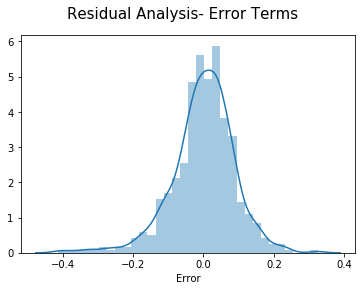

In [336]:
#distribution plot of error terms
plt.suptitle("Residual Analysis- Error Terms",fontsize=15)
sns.distplot((y_train-y_pred_train))
plt.xlabel("Error")
plt.show()

The error terms are normally distributed so we can proceed with it to predict on test data

## Scaling
Scaling Test Data

In [337]:
df_test[cont_f]=scaler.transform(df_test[cont_f])

In [338]:
df_test.describe()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_Spring,season_Summer,season_Winter,...,mnth_Sep,weathersit_LightSnow_LightRain_Thunderstorm_ScatteredClouds,weathersit_Mist_CloudyMist_BrokenClouds_FewClouds,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thr,weekday_Tue,weekday_Wed,yr_2019
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,...,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,0.036530,0.698630,0.558941,0.532991,0.638508,0.313350,0.520592,0.255708,0.264840,0.232877,...,0.086758,0.027397,0.319635,0.127854,0.118721,0.146119,0.164384,0.164384,0.100457,0.479452
std,0.188034,0.459904,0.233698,0.217888,0.148974,0.159947,0.218435,0.437258,0.442259,0.423633,...,0.282125,0.163612,0.467403,0.334692,0.324202,0.354034,0.371472,0.371472,0.301297,0.500722
min,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.048205,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.354650,0.344751,0.527265,0.198517,0.377531,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.558691,0.549198,0.627737,0.299459,0.524275,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.759096,0.714132,0.743928,0.403048,0.672745,1.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,0.963300,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [339]:
#Separate out target feature
y_test=df_test.pop('cnt')
x_test=df_test

In [340]:
#use the same features in test data as on training data
x_train=x_train.drop(['const'],axis=1)
x_test=x_test[x_train.columns]

In [341]:
#adding constant term
x_test=sm.add_constant(x_test)

In [342]:
#predict on test data
y_pred=lr5.predict(x_test)

# Model Evaluation

In [343]:
#R2 score on test data
r2_score(y_test,y_pred)

0.8033850605733448

The model can explain 80.34% variance on test data

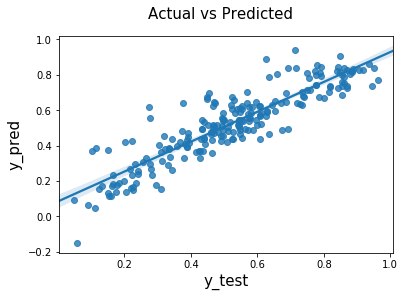

In [344]:
#Actual vs Predicted
fig=plt.figure()
ax1=fig.add_subplot(111)
plt.suptitle('Actual vs Predicted',fontsize=15)
#ax1.scatter(y_test,c='b',label='y_test')
#ax1.scatter(y_pred,c='r',label='y_pred')
sns.regplot(y_test,y_pred)
plt.xlabel("y_test",fontsize=15)
plt.ylabel("y_pred",fontsize=15)
plt.show()

The actual & predicted gets overlapped which shows the model can predict the change in actual data in a good way

In [345]:
#creating a dataframe of features & coefficients
coef=pd.DataFrame(lr5.params)
coef.insert(0,'Features',coef.index)
coef.rename(columns={0:'Coefficient'},inplace=True)
coef.reset_index(drop=True,inplace=True)
coef.sort_values(by='Coefficient',ascending=False,inplace=True)
coef

,Features,Coefficient
1,temp,0.598625
11,yr_2019,0.228436
0,const,0.223111
5,season_Winter,0.135878
7,mnth_Sep,0.091479
4,season_Summer,0.082251
10,weekday_Sun,-0.041966
6,mnth_Jul,-0.043909
9,weathersit_Mist_CloudyMist_BrokenClouds_FewClouds,-0.052904
2,hum,-0.174126


The top indicators of increasing demand are 
- temperature
- season (mainly in summer & winter)
- month(sep)

BoomBikes can take above indicators into consideration & offer business benifits to attract more customers & gain profit

The Positive coefficients depicts the increase in count for those parameters & Negative coefficient signifies decrease in count




The Equation of the best fit line obtained is

cnt = 0.598625 * temp + 0.228436 * yr_2019 + 0.135878 * season_Winter + 0.091479 * mnth_Sep + 0.082251 * season_Summer + (-0.041966) * weekday_Sun  + (-0.043909) * mnth_Jul + (-0.052904) * weathersit_Mist_CloudyMist_BrokenClouds_FewClouds + (-0.174126) * hum + (-0.189487) * windspeed + (-0.235432) * weathersit_LightSnow_LightRain_Thunderstorm_ScatteredClouds + 0.223111


Inferences

- Temperature is a deciding factor with high coefficient
- Rentals are high during summer & winter
- Month of september sees a rise in rentals while dips in July
- Humidity & windspeed acts as a hindrance to rentals
- Weather situation for mist,snow,clouds & rain also acts negatively